In [1]:
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import wandb
from torch.utils.data import DataLoader, Dataset
from copy import deepcopy
from torch.autograd import Variable
from tqdm import tqdm
from pprint import pprint
from PIL import Image
from sklearn.model_selection import train_test_split
import os

In [2]:
DATASET_PATH = '/home/bk_anupam/code/ML/DeepLearningWSL/AutoEncoders/data/lfw-deepfunneled/'
ATTRIBUTES_PATH = '/home/bk_anupam/code/ML/DeepLearningWSL/AutoEncoders/data/'
class Config:
    RUNTIME = "LOCAL"
    SUBSET_FRACTION = 0.2
    NUM_EPOCHS = 50
    BATCH_SIZE = 64
    WANDB_KEY = ""
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on', Config.DEVICE)

Training on cuda


In [ ]:
class SchedulerConfig:
    # for ReduceLROnPlateau (number of epochs with no improvement after which the learning rate will be reduced)
    SCHEDULER_PATIENCE = 5  
    # for ReduceLROnPlateau (factor by which the learning rate will be reduced)
    FACTOR = 0.5 
    SCHEDULER = "ReduceLROnPlateau"
    T_0 = 10 # for CosineAnnealingWarmRestarts (Number of epochs before the first restart)
    MIN_LR = 5e-7 # for CosineAnnealingWarmRestarts (Minimum learning rate)
    T_mult = 1 # for CosineAnnealingWarmRestarts (Factor by which Ti(number of epochs between two restarts) increases)
    MAX_LR = 1e-3 # for CosineAnnealing (Initial learning rate)
    STEPS_PER_EPOCH = 13 # for OneCycleLR
    STEP_SIZE = 10 # for StepLR
    GAMMA = 0.5 # for StepLR

In [4]:
if Config.RUNTIME == "KAGGLE":
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    WANDB_KEY = user_secrets.get_secret("wandb")
    DATASET_PATH = "/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"

# Log in to W&B
os.environ["WANDB_API_KEY"] = WANDB_KEY

# Initialize W&B
wandb.init(project="simple_autoencoder", name="test_run")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bkanupam. Use `wandb login --relogin` to force relogin


In [5]:
img_df = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    img_df.append({"person":person, "path": path})
    
img_df = pd.DataFrame(img_df)
#too much Bush
img_df = img_df.groupby("person").filter(lambda x: len(x) < 25 )
img_df.head(10)

,person,path
0,Ellen_Saracini,/home/bk_anupam/code/ML/DeepLearningWSL/AutoEn...
1,Lydia_Shum,/home/bk_anupam/code/ML/DeepLearningWSL/AutoEn...
2,Yale_Kamisar,/home/bk_anupam/code/ML/DeepLearningWSL/AutoEn...
3,Pinar_del_Rio,/home/bk_anupam/code/ML/DeepLearningWSL/AutoEn...
4,Larry_Tanenbaum,/home/bk_anupam/code/ML/DeepLearningWSL/AutoEn...
5,Kristen_Rivera,/home/bk_anupam/code/ML/DeepLearningWSL/AutoEn...
6,Matt_Siebrandt,/home/bk_anupam/code/ML/DeepLearningWSL/AutoEn...
7,Ringo_Starr,/home/bk_anupam/code/ML/DeepLearningWSL/AutoEn...
8,Lee_Ann_Knight,/home/bk_anupam/code/ML/DeepLearningWSL/AutoEn...
9,Tanya_Holyk,/home/bk_anupam/code/ML/DeepLearningWSL/AutoEn...


<Axes: xlabel='person'>

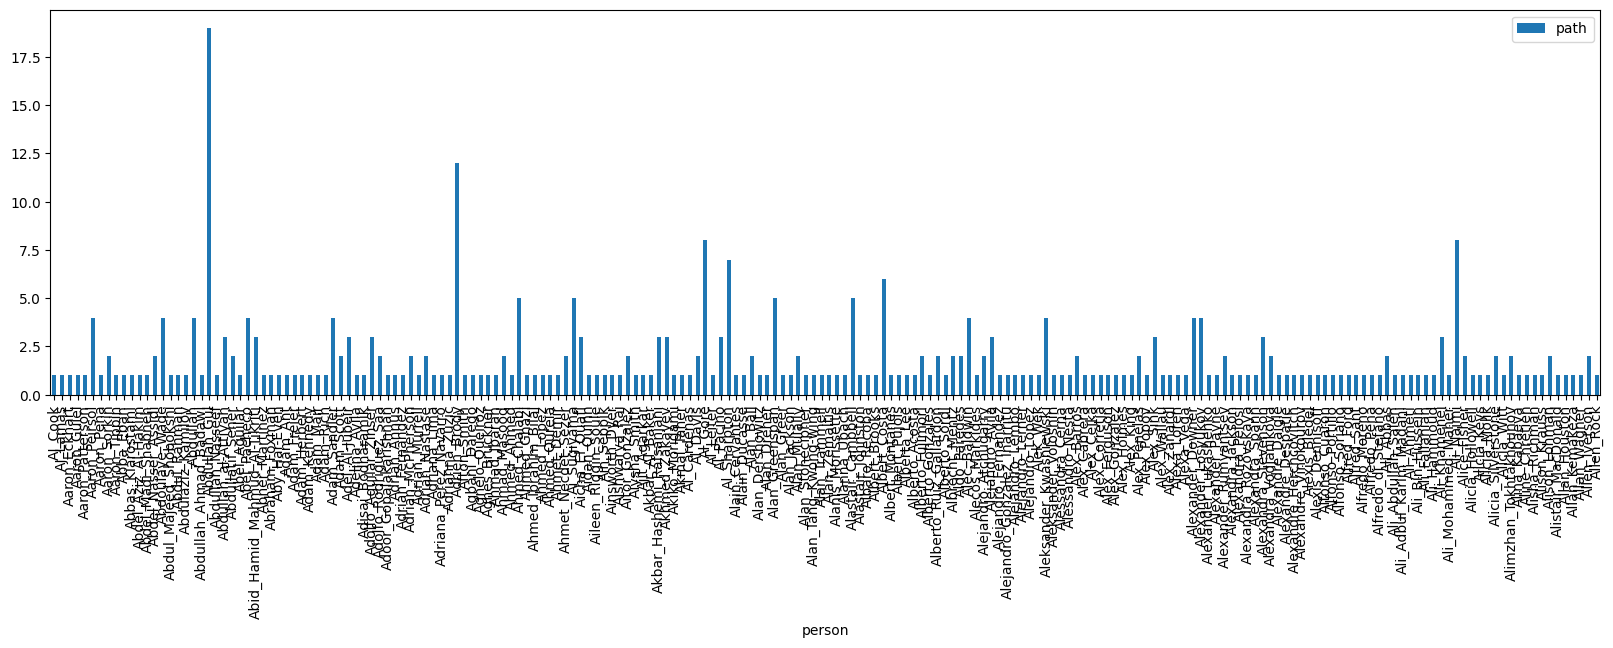

In [6]:
img_df.groupby("person").count()[:200].plot(kind='bar', figsize=(20,5))

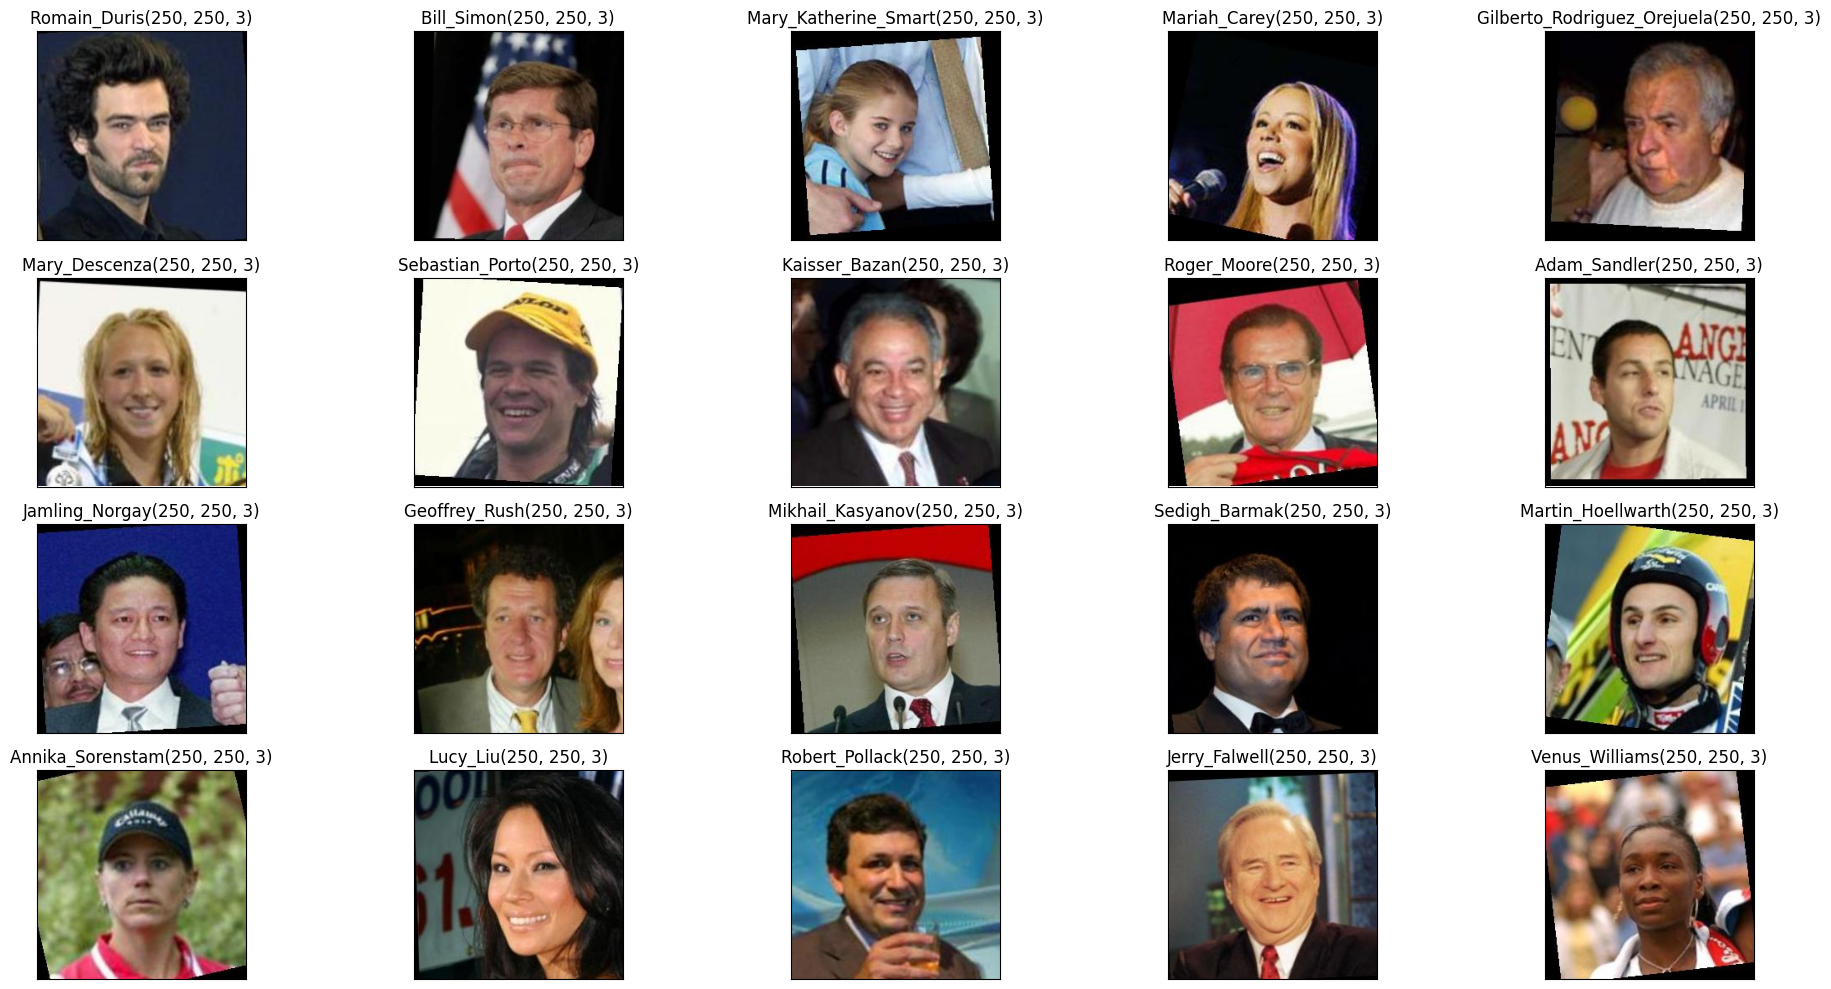

In [7]:
plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(img_df))
    img = plt.imread(img_df.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(img_df.person.iloc[idx]+str(img.shape))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [8]:
# Custom Dataset for loading images
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        # image metdadata dataframe containing image path and attributes
        self.df = df        
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # idx is index in the image metadata dataframe
        img_path = self.df.loc[idx, "path"]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [9]:
# Function to display input and output images
def display_images(input_img, output_img, epoch):    
    fig, axes = plt.subplots(1, 2, figsize=(4, 2))
    axes[0].imshow(input_img)
    #axes[0].set_title(f"Input-Epoch {epoch}")
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[1].imshow(output_img)
    #axes[1].set_title(f"Output-Epoch {epoch}")
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    plt.show()

In [10]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(-1, *self.shape)

In [11]:
# Simple CNN Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # (64, 125, 125)
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # (128, 63, 63)
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),# (256, 32, 32)
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),# (512, 16, 16)
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(512*16*16, 128)  # bottleneck
        )
        # Decoder
        self.decoder = nn.Sequential(
            # Input shape: (128,) from bottleneck layer
            nn.Linear(128, 512*16*16),  # reshape to (512, 16, 16)
            nn.ReLU(True),
            Reshape((512, 16, 16)),
            # For transposed convolution:  n_out = (n_in-1)*stride - 2*padding + kernel_size + output_padding
            # n_out = (16-1)*2 - 2*1 + 3 + 1 = 32
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1), # (256, 32, 32)
            nn.ReLU(True),
            # n_out = (32-1)*2 - 2*1 + 3 + 0 = 63
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=0), # (128, 63, 63)
            nn.ReLU(True),
            # n_out = (63-1)*2 - 2*1 + 3 + 0 = 125
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=0),  # (64, 125, 125)
            nn.ReLU(True),
            # n_out = (125-1)*2 - 2*1 + 3 + 1 = 250
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),    # (3, 250, 250)
            nn.Sigmoid()  # Use sigmoid to bring output values between [0, 1]
        )                

    def forward(self, x):
        x = self.encoder(x)
        # print(f"after encoding x.shape = {x.shape}")
        x = self.decoder(x)
        # print(f"after decoding x.shape = {x.shape}")
        return x

In [12]:
# split img_df into train and test
if Config.SUBSET_FRACTION is not None:
    img_df = img_df.sample(frac=Config.SUBSET_FRACTION, random_state=42).reset_index(drop=True)
train_df, val_df = train_test_split(img_df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [13]:
def train_model(model, train_loader, valid_loader, optimizer, scheduler, criterion, eval_metric, device, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for data in train_loader:
            #print(f"input.shape = {data.shape}")
            inputs = data.to(device)
            outputs = model(inputs)
            #print(f"output.shape = {outputs.shape}")
            loss = criterion(outputs, inputs)        
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        valid_loss = 0
        valid_metric = 0
        with torch.no_grad():
            for data in valid_loader:
                inputs = data.to(device)  # Select a single image
                outputs = model(inputs)
                #display_images(input_img[0], output_img[0], epoch+1)
                valid_loss += criterion(outputs, inputs).item()                
                valid_metric += eval_metric(outputs, inputs).item()
        
        # Print epoch results including the current learning rate and evaluation metric
        print(f'Epoch {epoch+1}/{epochs}, '
              f'Training Loss: {train_loss/len(train_loader):.6f}, '
              f'Validation Loss: {valid_loss/len(valid_loader):.6f}, '
              f'Validation Metric: {valid_metric/len(valid_loader):.6f}, '
              f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
        # Log metrics to W&B
        wandb.log({
            "train_loss": train_loss/len(train_loader),
            "val_loss": valid_loss/len(valid_loader),
            "val_mse": valid_metric/len(valid_loader),
            "learning_rate": scheduler.get_last_lr()[0],
        }, step=epoch)
        
        val_img = inputs[0].permute(1, 2, 0).cpu().detach().numpy()
        output_img = outputs[0].permute(1, 2, 0).cpu().detach().numpy()
        display_images(val_img, output_img, epoch+1)
        # Step the scheduler
        scheduler.step()                

In [14]:
def mse_metric(predictions, targets):
    return torch.mean((predictions - targets) ** 2)

In [15]:
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor()
])

ds_train = ImageDataset(df=train_df, transform=transform)
ds_val = ImageDataset(df=val_df, transform=transform)
dl_train = DataLoader(ds_train, batch_size=Config.BATCH_SIZE, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=Config.BATCH_SIZE)

# Initialize model, loss function, and optimizer
model = ConvAutoencoder().to(Config.DEVICE)
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=SchedulerConfig.MAX_LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=SchedulerConfig.STEP_SIZE, gamma=SchedulerConfig.GAMMA)
eval_metric = mse_metric

train_model(model, dl_train, dl_val, optimizer, 
            scheduler=scheduler,
            criterion=criterion, 
            device=Config.DEVICE, 
            epochs=Config.NUM_EPOCHS,
            eval_metric=eval_metric)


KeyboardInterrupt: 